In [1]:
import numpy as np
import pandas as pd
import os.path
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


1) For each HUC region, calculate the 14-day running total of P99 counts. 
2) Normalize the running counts.
Relevant paper: https://hess.copernicus.org/articles/25/5153/2021/
 

reference:<br>
https://towardsdatascience.com/5-pandas-group-by-tricks-you-should-know-in-python-f53246c92c94

In [2]:
# explicit function to normalize array
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

In [3]:
dir_i = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/'
#dir_o = '/'

flnm = dir_i + 'ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt'
print(flnm)
df = pd.read_csv(flnm, sep=" ") 
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
#df.head()

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt


In [4]:
# Split Data into 'HUC2' Groups by .groupby() function. 
# This returns a GroupBy object which is a dictionary
# Then use different methods on this object 
huc2_g = df.groupby(['HUC2']) 

In [5]:
# number of unique groups
# the same as df.HUC2.nunique() 
n_huc2 = huc2_g.ngroups 
n_huc2

19

In [6]:
# group size : counts the number of rows in each group
huc2_g.size()

HUC2
Arkansas                1703
CoastalBasinsNP          442
Colorado                3604
Columbia                2947
GreatBasin              2124
GreatLakes              1893
LowerMississippi        1100
LowerMissouri           2198
None                    6787
NorthAtlantic           1251
Ohio                    2162
RedAndOuachita           831
RedRiver                 521
RioGrande               1639
SacramentoAndKlamath     802
Southeast               3052
Texas                   1707
UpperMississippi        1910
UpperMissouri           3316
dtype: int64

#### some info. about the group

In [7]:
# counts only the non-null values from each column
# whereas .size() simply returns the number of rows
#huc2_g.count()

In [8]:
# check the first and last records after data  is split 
# .first() gives first non-null values in each column, whereas .nth(0) returns the first row of the group, no matter what the values are.
#huc2_g.first()

In [9]:
# extracting 4th row in each group
#huc2_g.nth(3)

In [10]:
## extract specific group. get_group is fast
#huc2_g.get_group('Ohio')

In [11]:
# view 'HUC2' Groups
# huc2_g.groups

In [12]:
StartDay = datetime.datetime(1979, 1, 1,  0)
StopDay  = datetime.datetime(2020, 12, 31, 23)
#StartDay = datetime.datetime(1979, 1, 1,  0)
#StopDay  = datetime.datetime(1979, 1, 31, 23)
TimeDD   = pd.date_range(StartDay, end=StopDay, freq='d')

n_day = len(TimeDD)
# TimeDD

In [13]:
# GroupBy object is a dictionary, iterate through it as with dictionary 
# reference
# https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
window_size = 14
 
n_ActDD = n_day - window_size + 1

arr_2d  = np.zeros((n_huc2,n_ActDD), dtype=int )

flnm_o = 'n_p99.csv'

if os.path.exists(flnm_o):
    df = pd.read_csv('n_p99.csv', index_col= 0)
else:
    ct = 0
    # Iterating through Groups which is dictionary
    for name_of_group, contents_of_group in huc2_g:
        print (ct, name_of_group)
     
        event_date = contents_of_group[['event_id', 'date']]
     
        #print(event_date.head())
 
        # Loop through the TimeDD array to consider
        # every window of size 14
        i = 0
        while i < n_ActDD:
            window = TimeDD[i : i + window_size]
         
            # select rows between two values
            event_select = event_date[event_date['date'].between(window[0], window[-1])]
            if not event_select.empty:
                #print('window:', window[0], window[-1])
                #print('event_select:', event_select)
                arr_2d[ct,i] = event_select['event_id'].nunique()
                #print('count ',  arr_2d[ct,i])
            i += 1
            #print('---', ct, name_of_group) 
         
         
        ct += 1    
        print(i)  
    
    # create a dataframe use date as index, huc2_g.groups.keys() as columns
    # and drop 'None':axis{0 or ‘index’, 1 or ‘columns’}, default 0
    df = pd.DataFrame(np.transpose(arr_2d), columns = huc2_g.groups.keys(),
                index = TimeDD[:n_ActDD], dtype = int).drop(['None'], axis=1) 
    df.to_csv('n_p99.csv')  

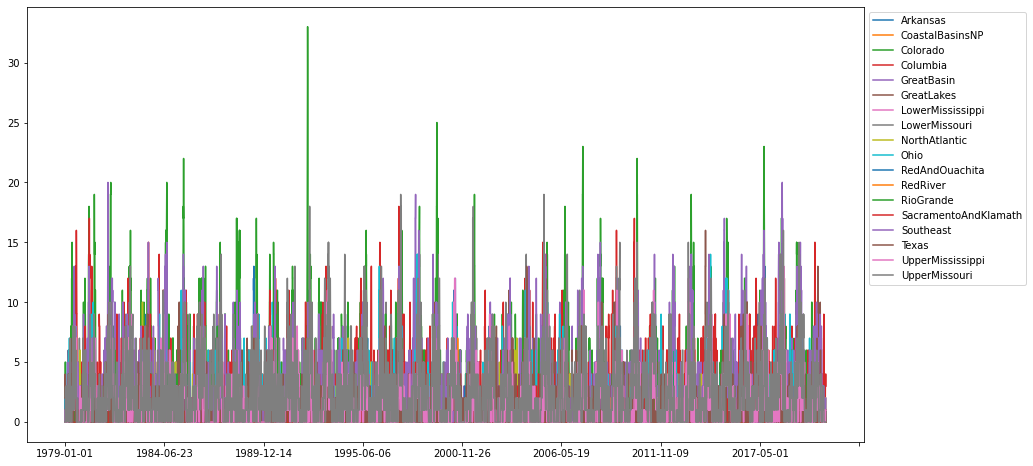

In [14]:
ax = df.plot(figsize=(15, 8))
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('n_p99.png', format='png', dpi=100);

In [15]:
df

,Arkansas,CoastalBasinsNP,Colorado,Columbia,GreatBasin,GreatLakes,LowerMississippi,LowerMissouri,NorthAtlantic,Ohio,RedAndOuachita,RedRiver,RioGrande,SacramentoAndKlamath,Southeast,Texas,UpperMississippi,UpperMissouri
1979-01-01,1,0,3,1,1,1,1,1,1,3,0,0,0,1,1,2,0,0
1979-01-02,1,0,3,1,1,1,0,1,1,1,0,0,0,1,1,2,0,0
1979-01-03,1,0,3,1,1,1,0,1,0,1,0,0,0,1,0,2,0,0
1979-01-04,1,0,5,1,1,1,0,1,0,1,0,0,0,1,0,2,0,0
1979-01-05,1,0,5,1,1,1,0,0,0,1,1,0,0,1,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,0,0,0,4,0,0,0,0,2,1,0,0,0,0,1,0,1,0
2020-12-15,0,0,0,4,0,0,0,0,1,1,0,0,0,0,1,0,1,0
2020-12-16,1,0,0,4,0,0,0,0,1,1,0,0,0,0,1,0,1,0
2020-12-17,1,0,0,4,0,0,0,0,0,1,1,0,0,0,1,0,1,0


normalize the 2d array

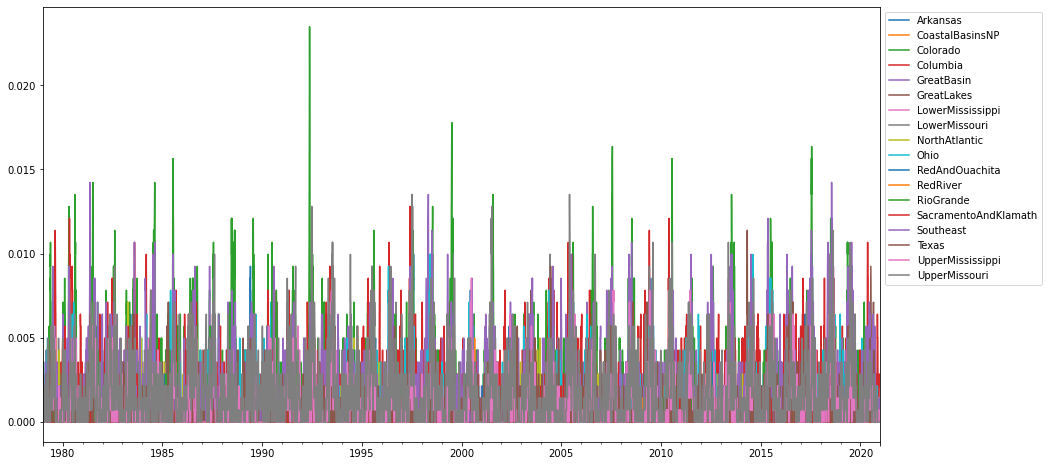

In [16]:
arr_2d = df.to_numpy()
#normalized_matrix = normalize_2d(matrix)
df_n = pd.DataFrame(normalize_2d(arr_2d), columns = df.columns.tolist(),
                index = TimeDD[:n_ActDD]) 
ax_n = df_n.plot(figsize=(15, 8))
ax_n.legend(bbox_to_anchor=(1.0, 1.0));

sklearn.preprocessing.normalize scales each sample vector to unit norm. (The default axis is 1, not 0.

In [17]:
df_n = pd.DataFrame(normalize(arr_2d), columns = df.columns.tolist(),
                index = TimeDD[:n_ActDD]) 
ax_n = df_n.plot(figsize=(15, 8))
ax_n.legend(bbox_to_anchor=(1.0, 1.0));